In [1]:
import os
os.chdir('../../')

In [2]:
cd = os.getcwd()
functions_path = os.path.join(cd, '02_code/functions')

In [3]:
import scanpy as sc
import scanpy.external as sce
import numpy as np
import pandas as pd
import anndata as ad
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.sparse import csr_matrix
from anndata import AnnData
import skmisc
import regex as re
import scipy.stats as stats
from itertools import combinations
import random

import anndata2ri
import logging
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro
rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

# from scipy.sparse import csr_matrix
import sys
sys.path.append(functions_path)
import functions_dat_processing as dp
import functions_plotting as dplt
import functions_for_CAR_annotation as ca
import functions_OVA_annotation as oa

/tmp/ipykernel_1765474/3991900642.py:22: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [4]:
#if needed, reload functions
import importlib
importlib.reload(dp)
importlib.reload(dplt)
importlib.reload(ca)
importlib.reload(oa)

<module 'functions_OVA_annotation' from '/home/s377963/car_t_sc/02_code/functions/functions_OVA_annotation.py'>

In [76]:
bioc = ro.packages.importr('BiocManager') 
# bioc.install('edgeR')
bioc.install('DESeq2')

* installing *source* package ‘DESeq2’ ...
** using staged installation
** libs
using C++ compiler: ‘x86_64-conda-linux-gnu-c++ (conda-forge gcc 14.1.0-0) 14.1.0’


x86_64-conda-linux-gnu-c++ -std=gnu++17 -I"/home/s377963/mambaforge/envs/scanpy/lib/R/include" -DNDEBUG  -I'/home/s377963/mambaforge/envs/scanpy/lib/R/library/Rcpp/include' -I'/home/s377963/mambaforge/envs/scanpy/lib/R/library/RcppArmadillo/include' -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/s377963/mambaforge/envs/scanpy/include -I/home/s377963/mambaforge/envs/scanpy/include -Wl,-rpath-link,/home/s377963/mambaforge/envs/scanpy/lib    -fpic  -fvisibility-inlines-hidden  -fmessage-length=0 -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/s377963/mambaforge/envs/scanpy/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1723488709275/work=/usr/local/src/conda/r-base-4.3.3 -fdebug-prefix-map=/home/s377963/mambaforge/envs/scanpy=/usr/local/src/conda-prefix  -c DESeq2.cpp -o DESeq2.o
x86_64-conda-linux-gnu-c++ -std=gnu++17 -I"/home/s377963/mambaforge/envs/scanpy/lib/R/includ

installing to /home/s377963/mambaforge/envs/scanpy/lib/R/library/00LOCK-DESeq2/00new/DESeq2/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (DESeq2)


Update all/some/none? [a/s/n]: 

array(['DESeq2'], dtype='<U6')

In [ ]:
seurat = ro.packages.importr('Seurat')
edgeR = ro.packages.importr('edgeR')
edgeR = ro.packages.importr('DESeq2')


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

# Load Data

In [ ]:
#import data

# adata_raw = sc.read_h5ad('./01_data/processed/merged_and_processed/XXXCAR_genome/XXXCAR_genome_raw_demultiplexed.h5ad') 
# adata_qc = sc.read_h5ad('./01_data/processed/merged_and_processed/XXXCAR_genome/XXXCAR_genome_after_qc.h5ad')
# adata_TIL_only = diff_diff_adata_qc[adata_qc.obs.Location != 'dLN']
# adata_pureTC = sc.read_h5ad('./01_data/processed/merged_and_processed/XXXCAR_genome/XXXCAR_genome_after_qc_TIL_only_pure_TC_annotation.h5ad') 
# adata_only_pureTC = adata_pureTC[adata_pureTC.obs['is.pure_Tcell'] == 'Pure']
adata_pure_TC_annotated = sc.read_h5ad('./01_data/processed/merged_and_processed/XXXCAR_genome/XXXCAR_genome_after_qc_TIL_only_pure_TC_annotation_non_TC_filtered_TC_subtypes_annotated.h5ad') 
adata_only_annotatedTC = adata_pure_TC_annotated[~adata_pure_TC_annotated.obs['functional.cluster'].isna()]

In [ ]:
non_annotated = [adata_pure_TC_annotated, adata_only_annotatedTC]

In [ ]:
for adata in non_annotated:
    adata.obs.rename(columns={"HTO_classification": "Classification"}, inplace=True) 
    adata.obs.rename(columns={"functional.cluster": "Tcell_subtype"}, inplace=True)
    adata.obs.rename(columns={"pool": "dataset"}, inplace=True)
    rmvd_p = [int(dataset.replace("P", "")) - 1 for dataset in adata.obs['dataset']]
    adata.obs['dataset'] = rmvd_p

/tmp/ipykernel_1753311/939101785.py:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['dataset'] = rmvd_p


# Determine cytokine profile

In [8]:
adata_only_annotatedTC.obs.condition
# adata_only_annotatedTC.obs.day

AAACCTGCATGAAGTA-1_1     C
AAACCTGGTAGGACAC-1_1    DM
AAACGGGAGAAACCTA-1_1     C
AAACGGGAGCAACGGT-1_1     P
AAAGCAAAGGTGATTA-1_1    DM
                        ..
TTGCGTCTCAAGAAGT-1_9    DM
TTGGAACGTTAAGTAG-1_9     P
TTTATGCGTCTTGCGG-1_9    DM
TTTATGCTCCACGCAG-1_9     P
TTTGGTTTCCAAAGTC-1_9     C
Name: condition, Length: 3456, dtype: category
Categories (3, object): ['C', 'DM', 'P']

In [48]:
# Comprehensive list of cytokines categorized by function
cytokine_genes = [
    # Pro-Inflammatory Cytokines
    "Il1a", "Il1b", "Il18", "Il33", "Il36a", "Il36b", "Il36g", "Il37", "Il38",
    "Tnf", "Lta", "Baff", "April", "Il6", "Il17a", "Il17b", "Il17c", "Il17d", "Il17e", "Il17f",
    "Il12a", "Il12b", "Il23a", "Il27", "Il35",
    
    # Anti-Inflammatory Cytokines
    "Il10", "Tgfb1", "Tgfb2", "Tgfb3", "Il35",
    
    # Chemokines (CC family)
    "Ccl1", "Ccl2", "Ccl3", "Ccl4", "Ccl5", "Ccl7", "Ccl8", "Ccl11", "Ccl13",
    "Ccl17", "Ccl18", "Ccl19", "Ccl20", "Ccl21", "Ccl22", "Ccl25", "Ccl27",
    
    # Chemokines (CXC family)
    "Cxcl1", "Cxcl2", "Cxcl3", "Cxcl5", "Cxcl8", "Cxcl9", "Cxcl10", "Cxcl11",
    "Cxcl12", "Cxcl13", "Cxcl16",
    
    # Other Chemokines
    "Xcl1", "Xcl2", "Cx3cl1",
    
    # Interferons
    "Ifna1", "Ifna2", "Ifna4", "Ifna5", "Ifna6", "Ifna7", "Ifna9", "Ifna10", "Ifna11", "Ifna13",
    "Ifnb1", "Ifne", "Ifnk", "Ifnw1",
    "Ifng",
    "Ifnl1", "Ifnl2", "Ifnl3",
    
    # Growth Factors
    "Csf2", "Csf3", "Csf1", "Egf", "Vegfa", "Vegfb", "Vegfc", "Fgf1", "Fgf2",
    "Pdgfa", "Pdgfb", "Pdgfc", "Pdgfd", "Hgf", "Igf1", "Igf2",
    
    # T Cell-Derived Cytokines
    "Il2", "Il4", "Il5", "Il9", "Il13", "Il21", "Il22", "Il25",
    
    # Regulatory (Treg)
    "Il10", "Tgfb1", "Tgfb2", "Tgfb3", "Il35",
    
    # Other Cytokines
    "Spp1", "Il24", "Il26"
]

# If you just need a flat list of all cytokines:
# all_cytokines = sum([v if isinstance(v, list) else sum(v.values(), []) for v in cytokines.values()], [])

# Print all cytokines
# print(all_cytokines)


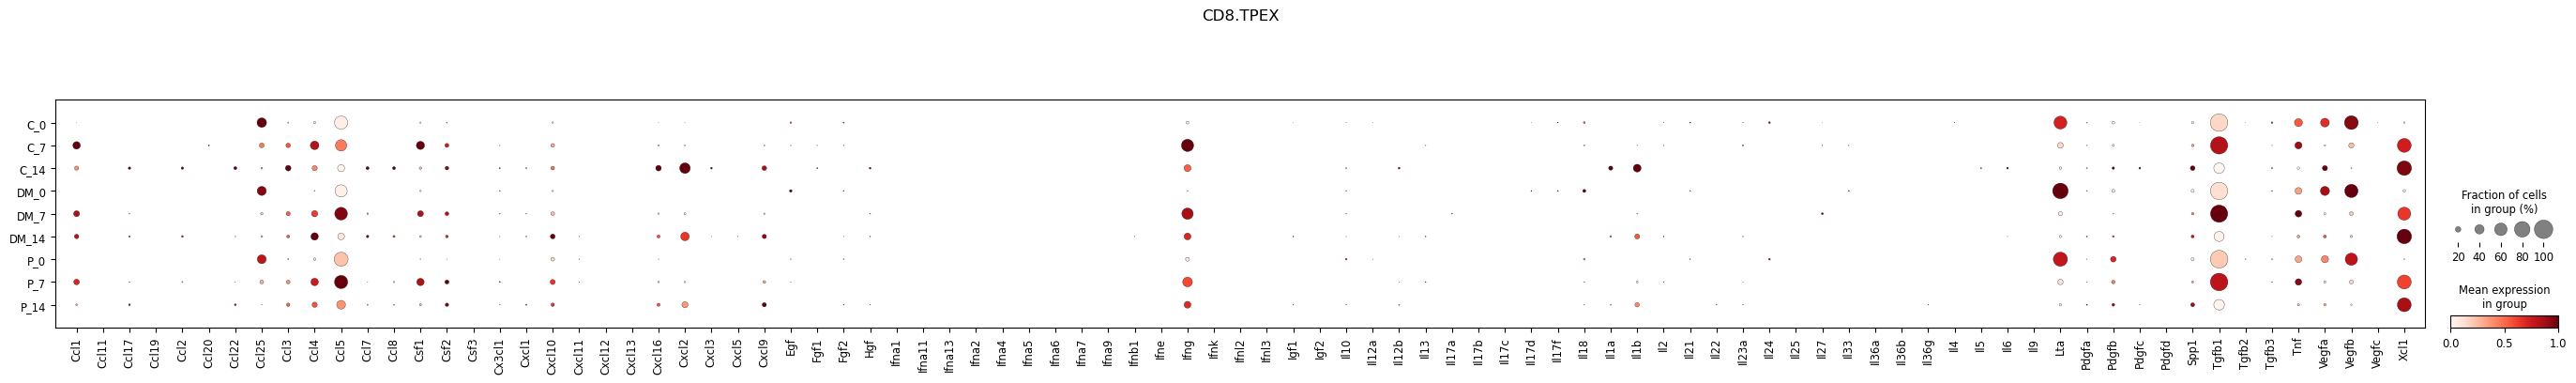

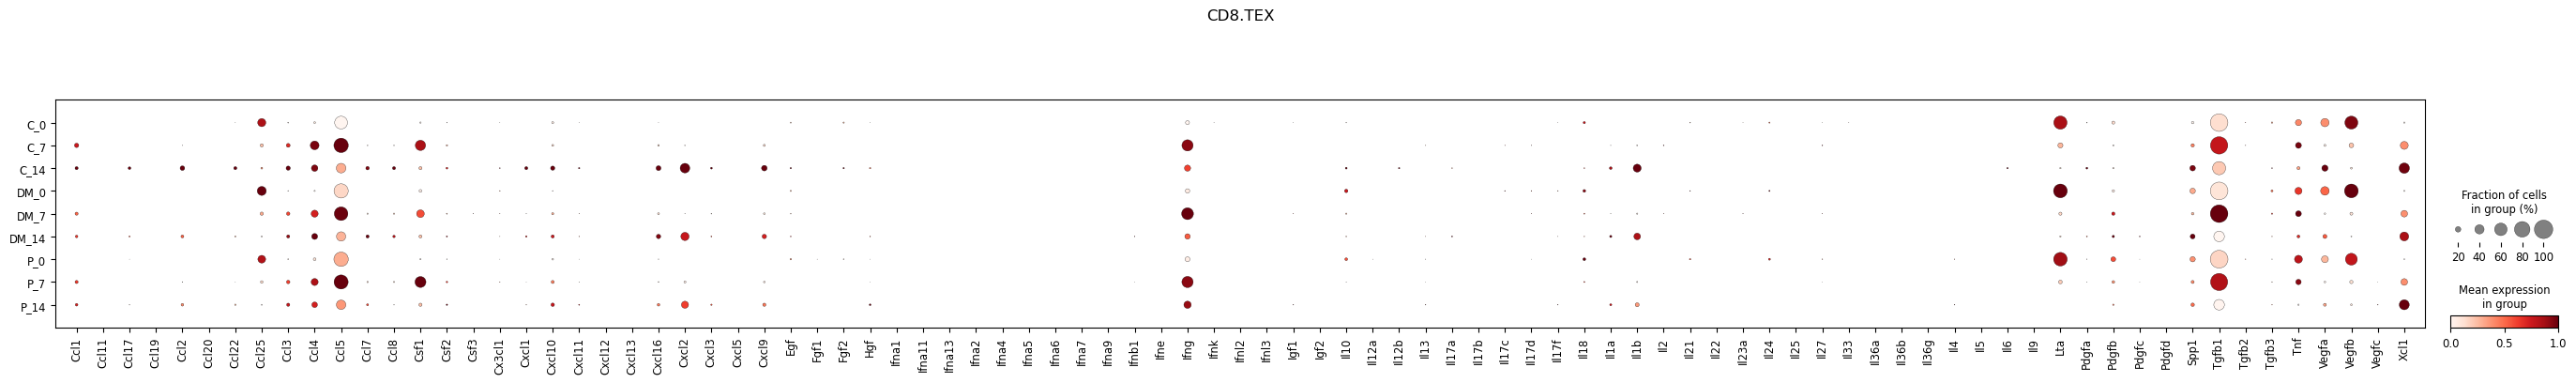

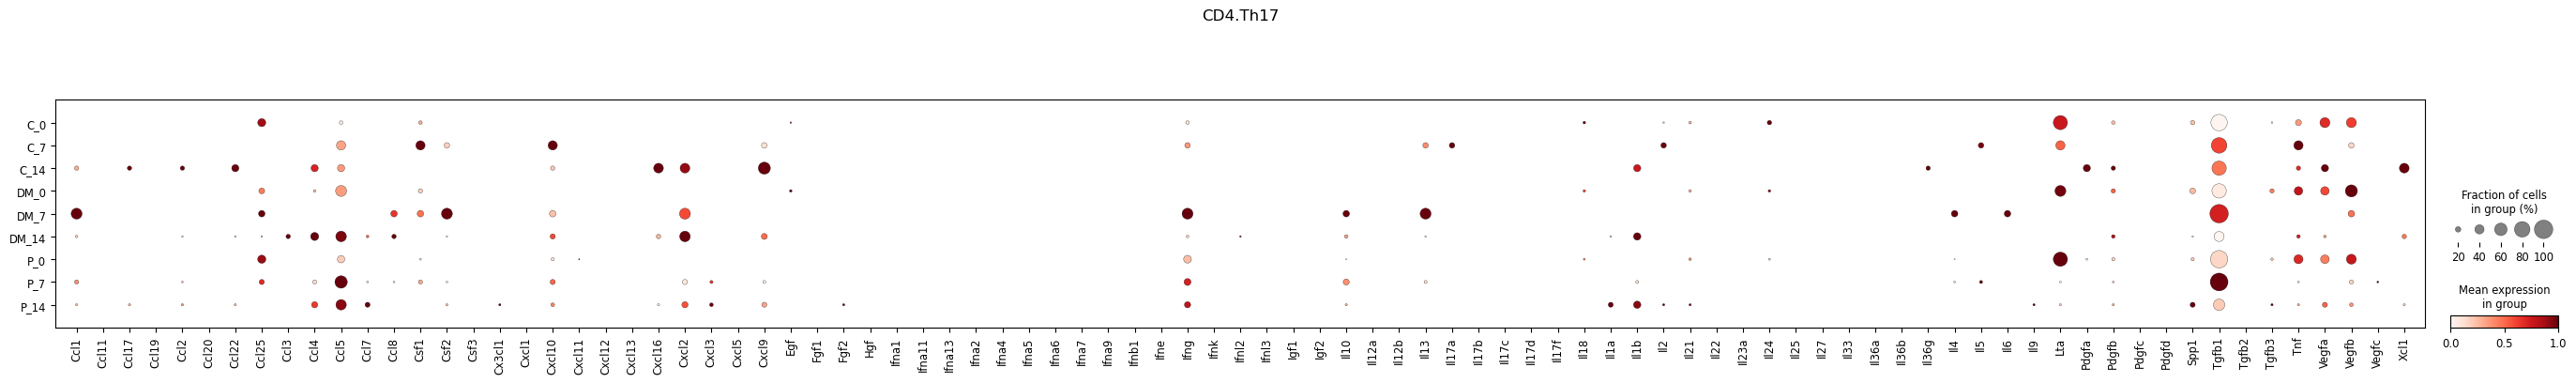

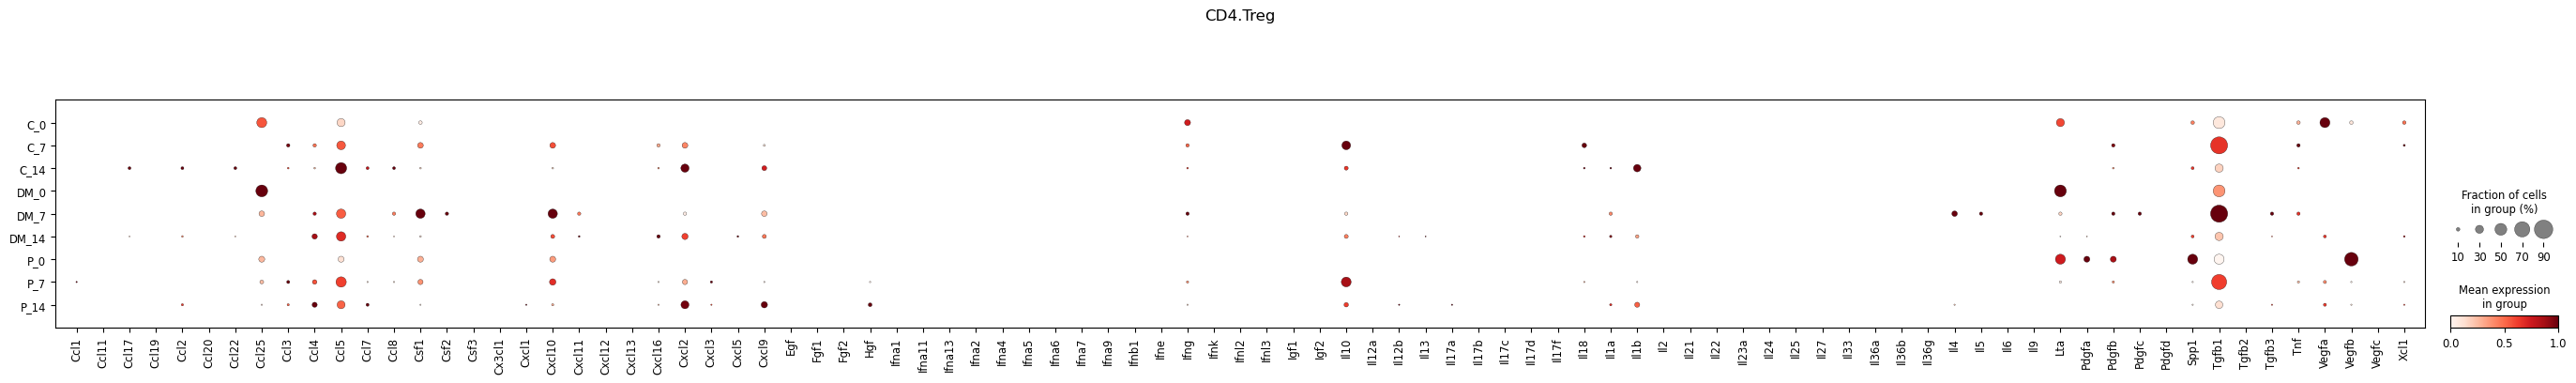

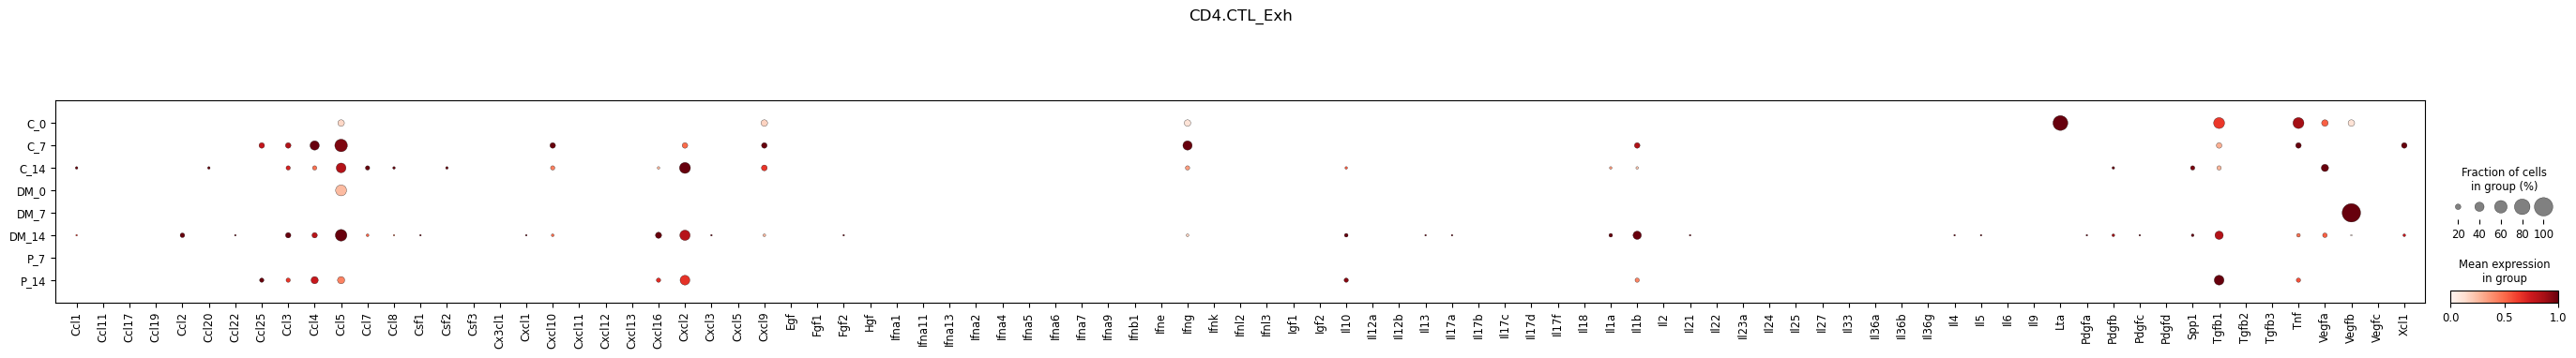

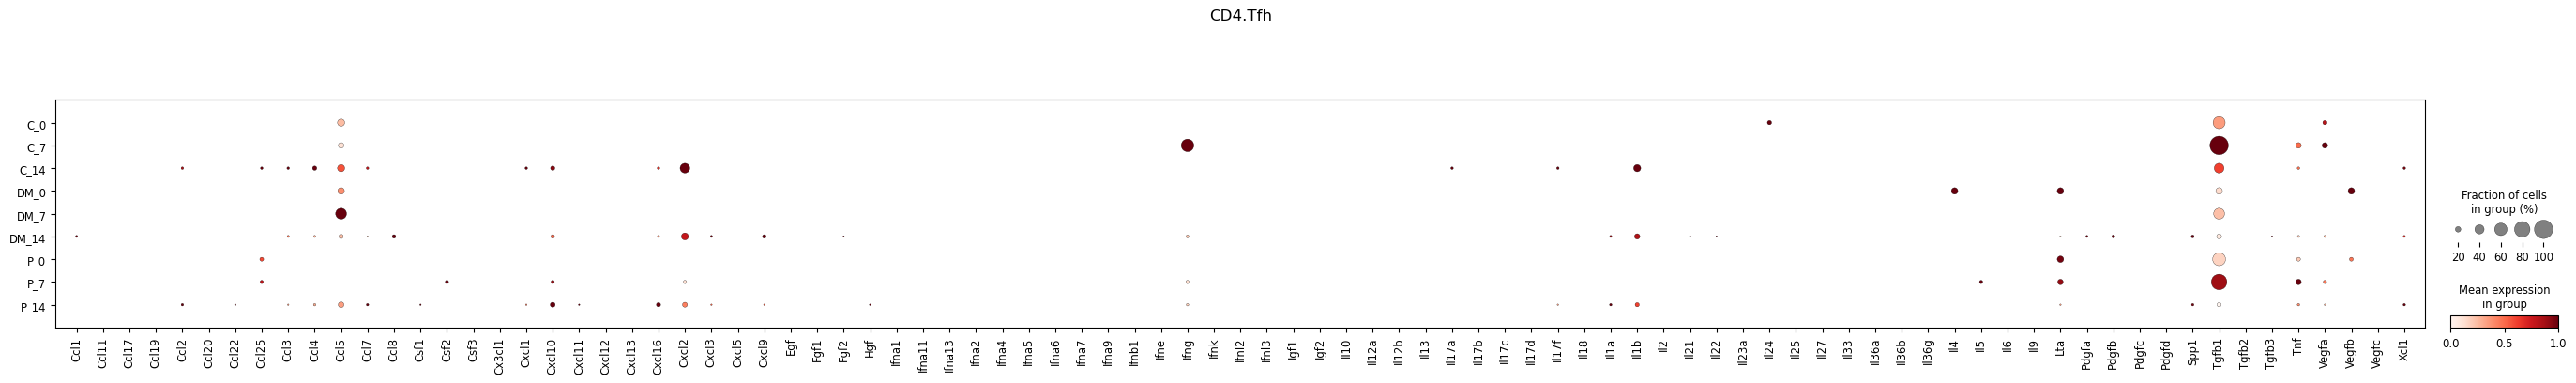

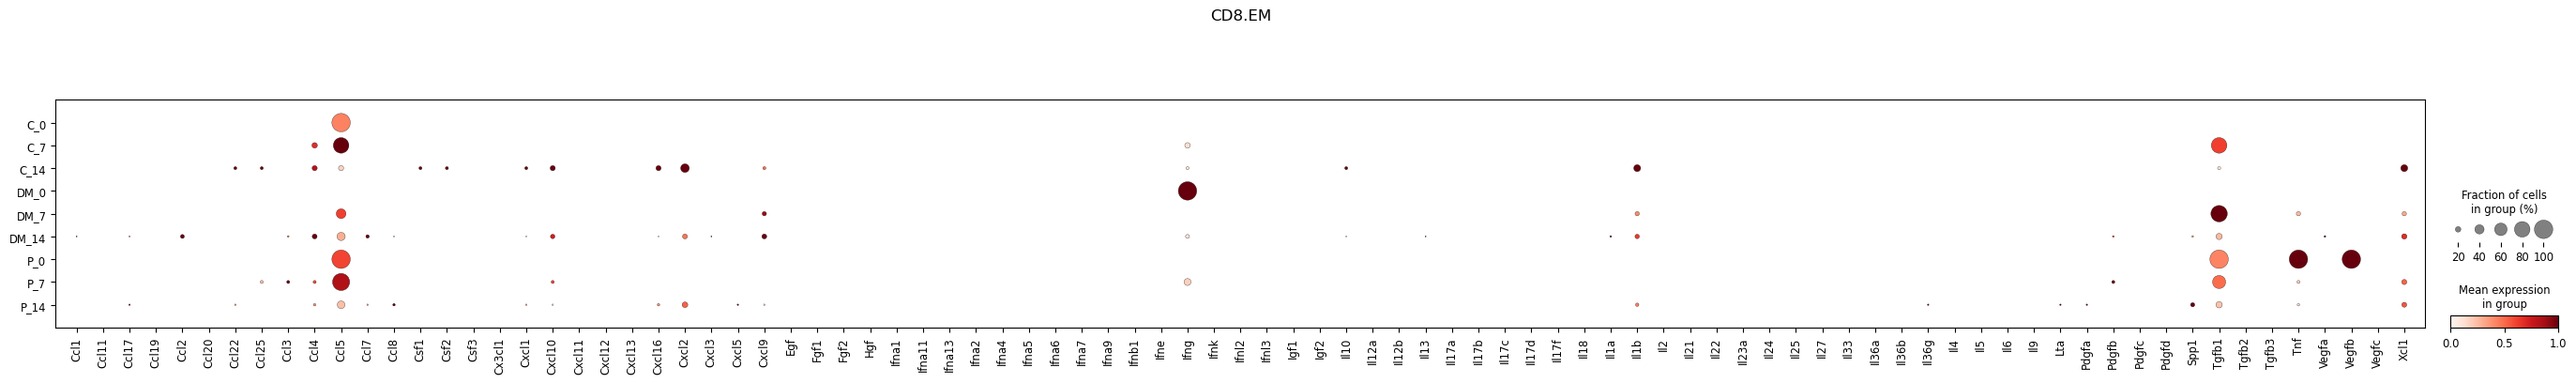

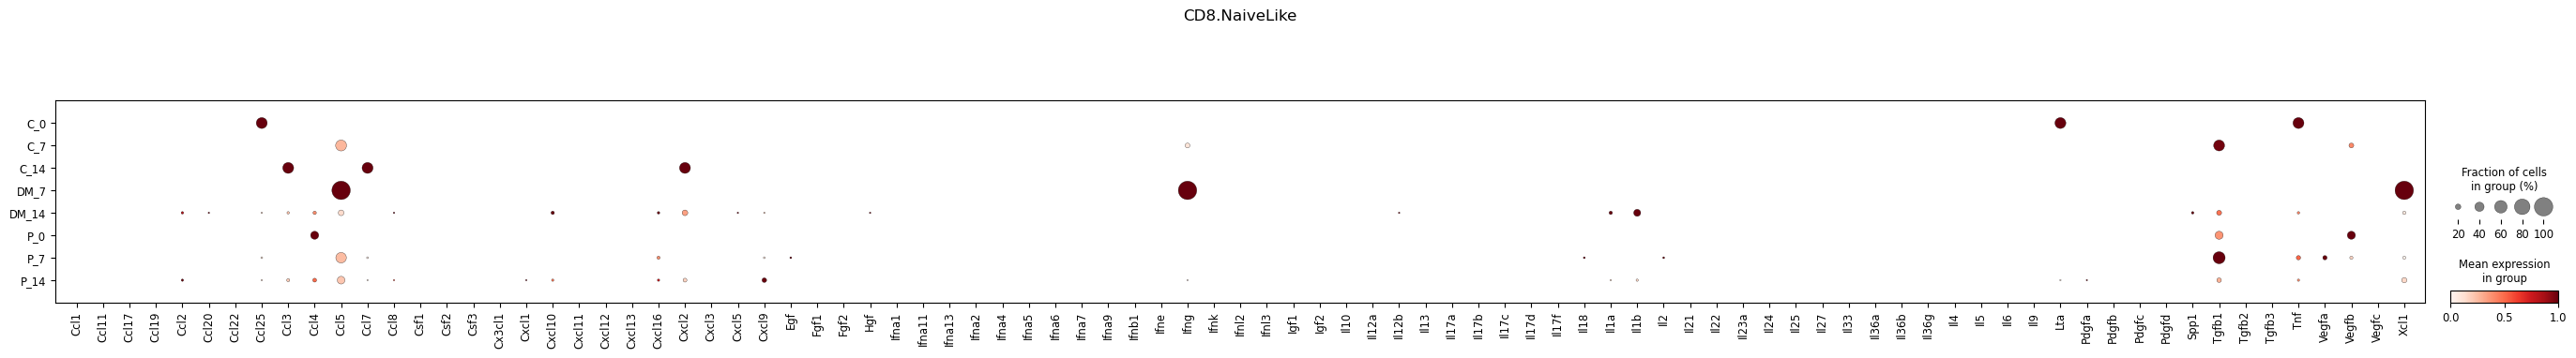

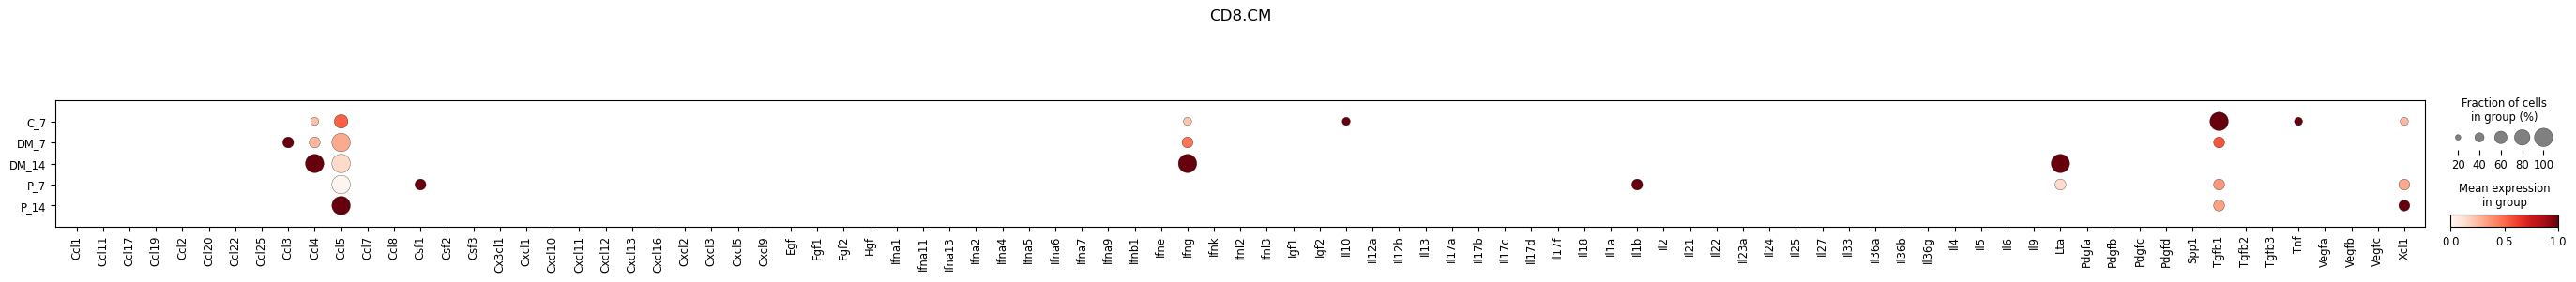

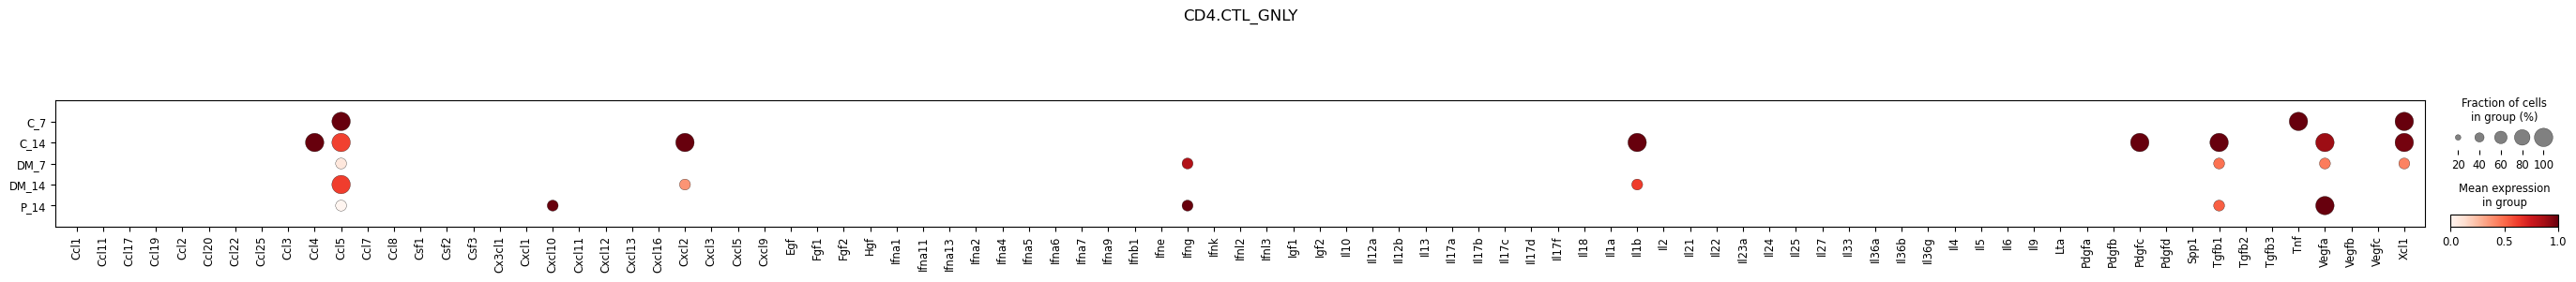

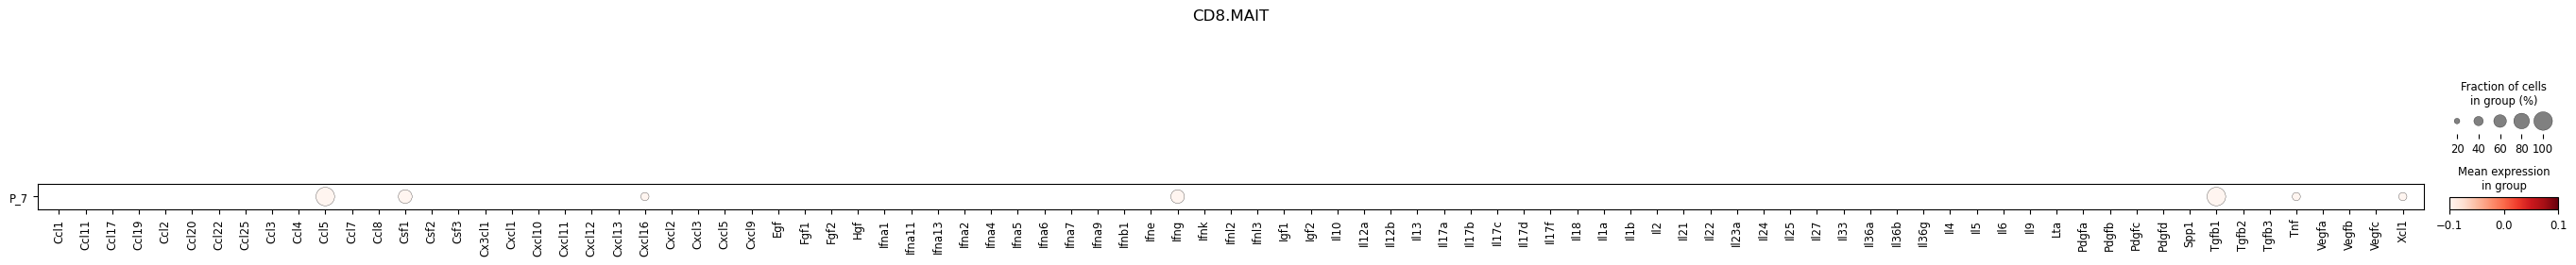

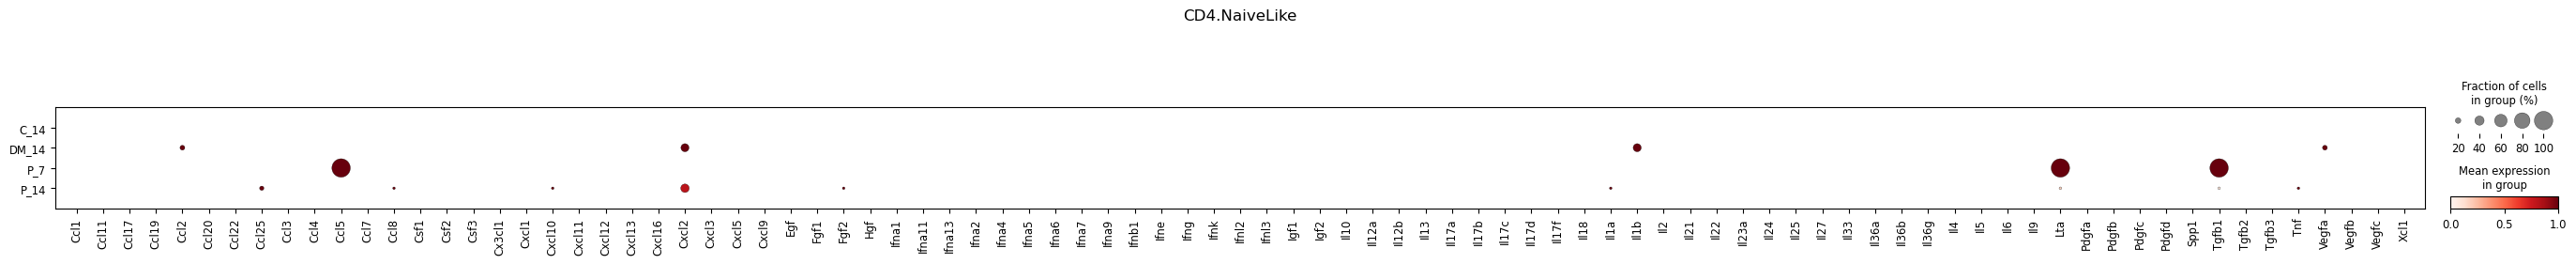

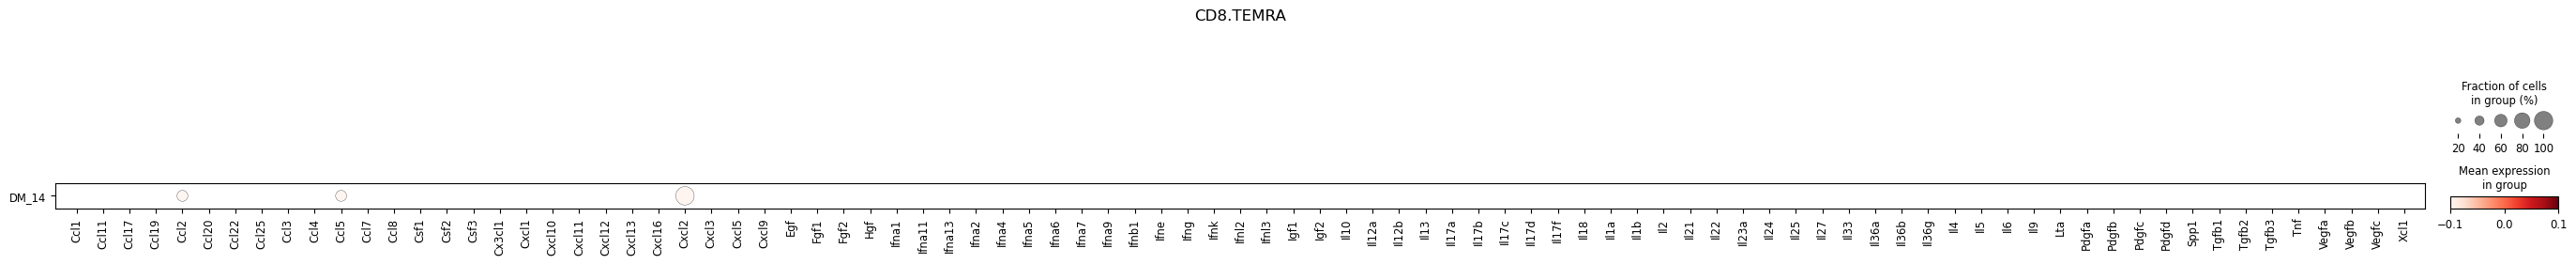

In [80]:
adata_only_annotatedTC.obs.Tcell_subtype
# var = ["Il2", "Ifng", "Tnf", "Il4", "Il10", "Il17a"]
# var = cytokines['Pro_Inflammatory']
subtypes = adata_only_annotatedTC.obs.Tcell_subtype.unique()

for subtype in subtypes:
    adata = adata_only_annotatedTC[adata_only_annotatedTC.obs.Tcell_subtype == subtype].copy()
    cytokines_in_adata = np.unique([gene for gene in cytokine_genes if gene in adata.var_names])
    sc.pl.dotplot(adata, cytokines_in_adata, groupby=["condition", "day"], standard_scale="var", swap_axes=False, cmap="Reds", title=subtype)

# for chemokine receptors

In [82]:
# Comprehensive list of chemokine receptors as gene symbols
chemokine_receptors = [
    # CC Chemokine Receptors (CCR family)
    "Ccr1", "Ccr2", "Ccr3", "Ccr4", "Ccr5", "Ccr6", "Ccr7", "Ccr8", "Ccr9", "Ccr10", "Ccr11",

    # CXC Chemokine Receptors (CXCR family)
    "Cxcr1", "Cxcr2", "Cxcr3", "Cxcr4", "Cxcr5", "Cxcr6", "Cxcr7",

    # Atypical Chemokine Receptors (ACKR family, formerly decoy/scavenger receptors)
    "Ackr1", "Ackr2", "Ackr3", "Ackr4",

    # CX3C Chemokine Receptor
    "Cx3cr1",

    # XC Chemokine Receptor
    "Xcr1"
]


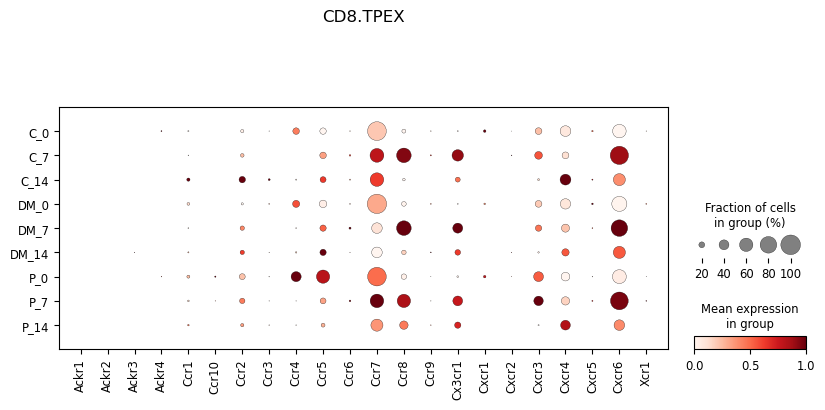

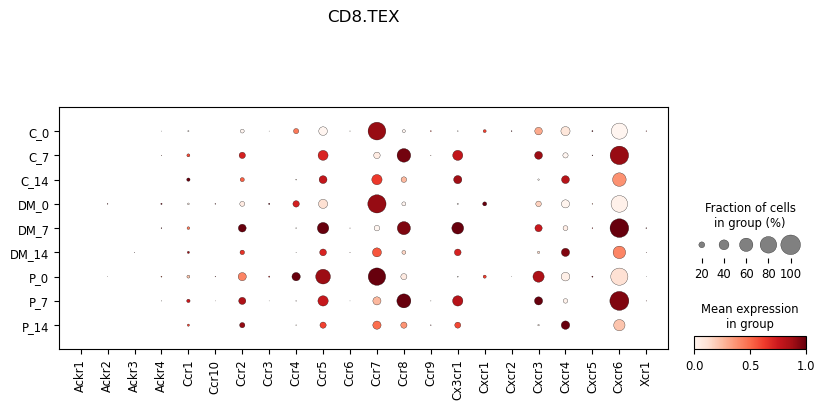

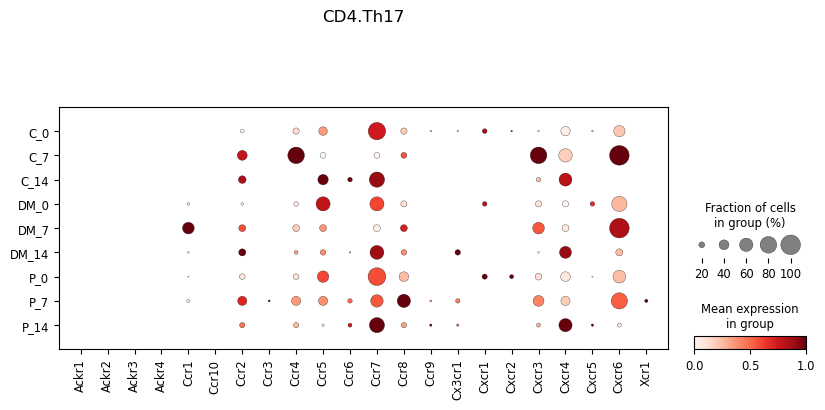

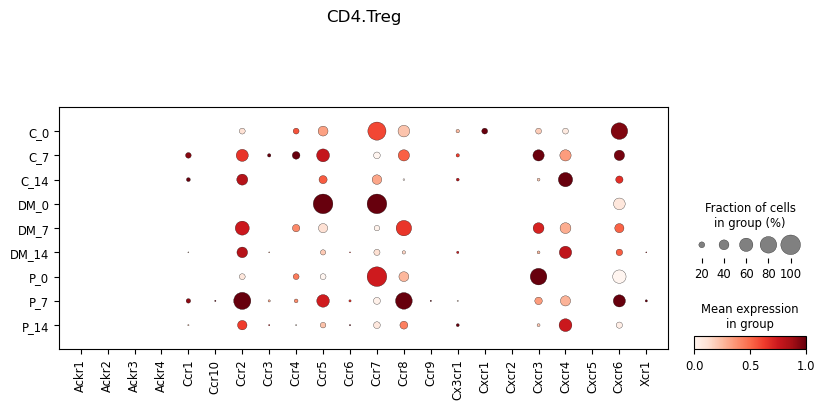

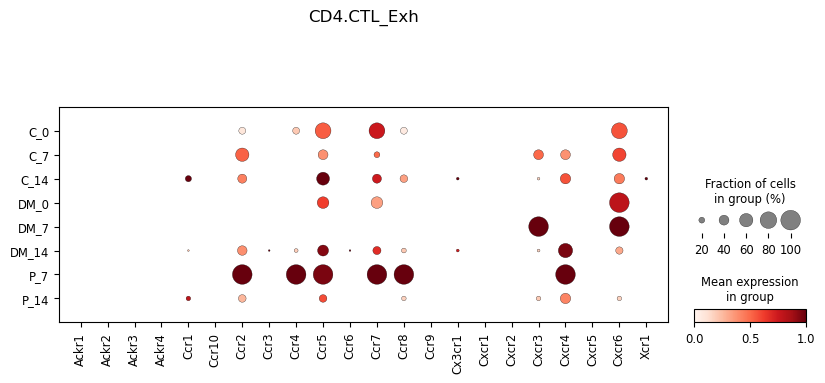

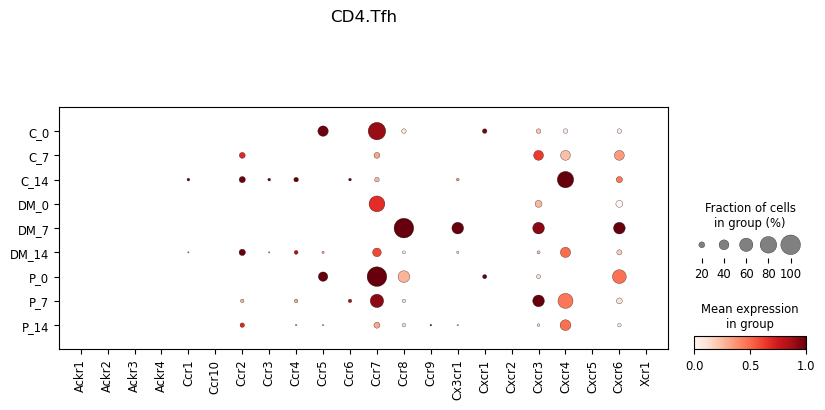

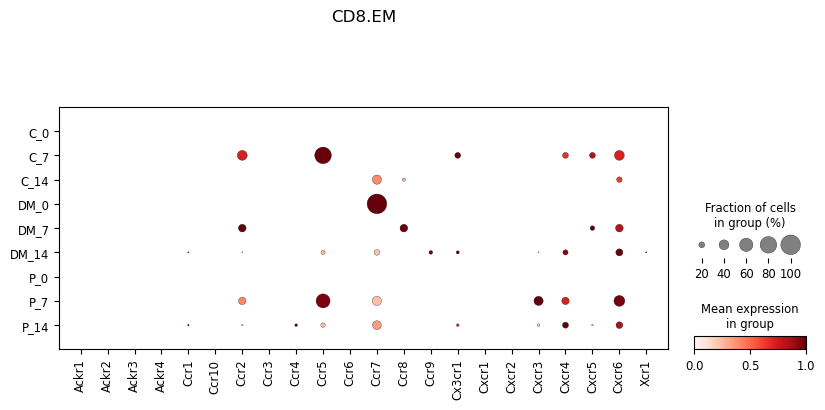

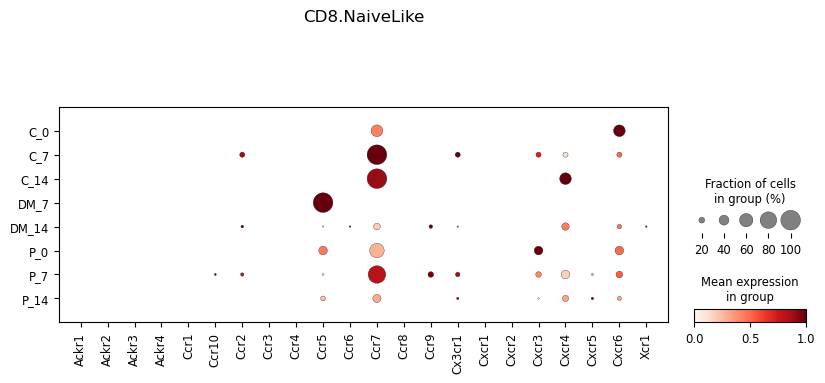

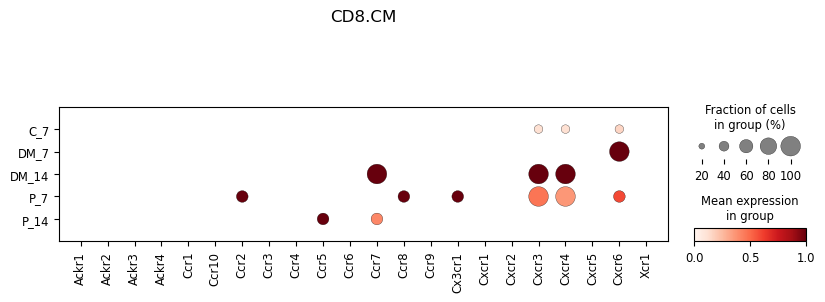

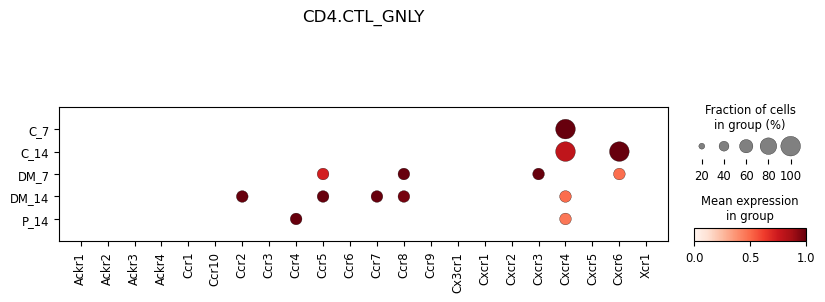

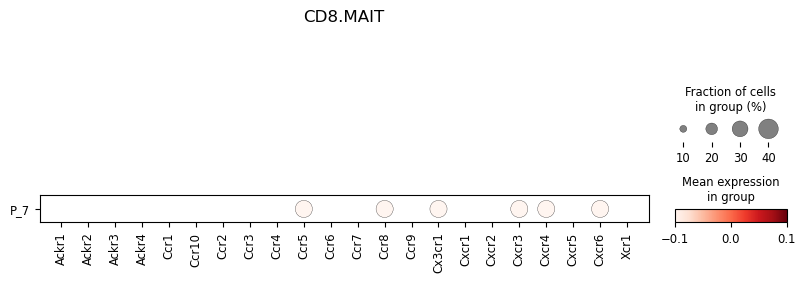

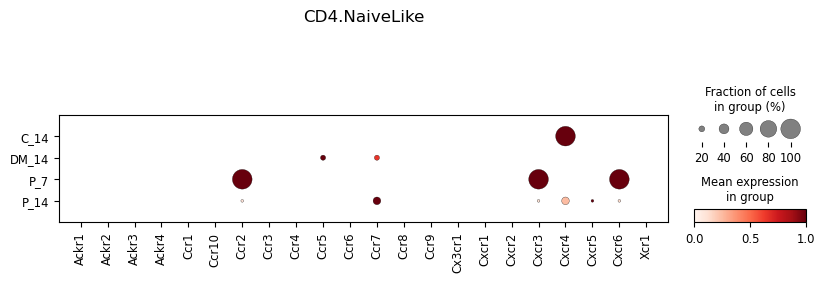

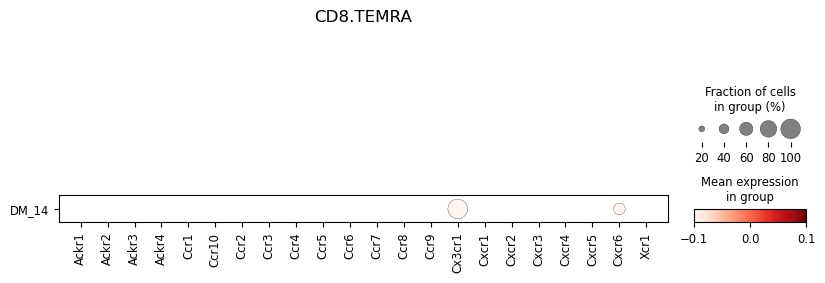

In [83]:
adata_only_annotatedTC.obs.Tcell_subtype
subtypes = adata_only_annotatedTC.obs.Tcell_subtype.unique()

for subtype in subtypes:
    adata = adata_only_annotatedTC[adata_only_annotatedTC.obs.Tcell_subtype == subtype].copy()
    chemokine_receptors_in_adata = np.unique([gene for gene in chemokine_receptors if gene in adata.var_names])
    sc.pl.dotplot(adata, chemokine_receptors_in_adata, groupby=["condition", "day"], standard_scale="var", swap_axes=False, cmap="Reds", title=subtype)

maiks recommendations to search for

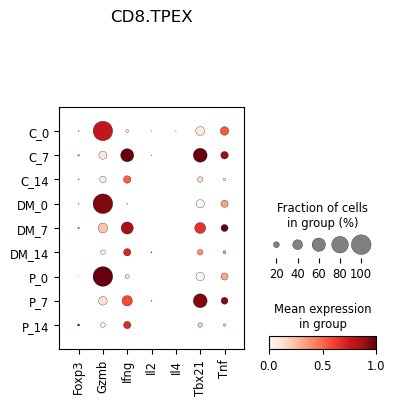

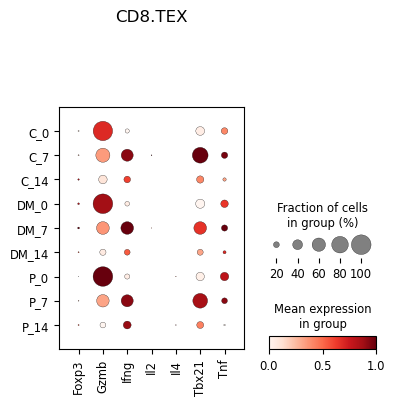

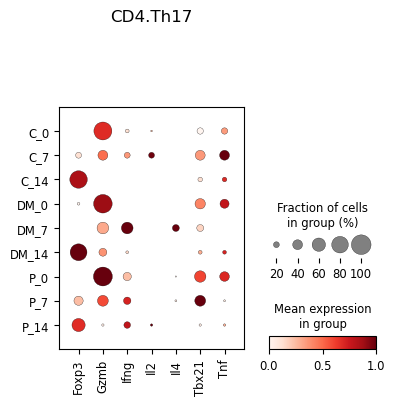

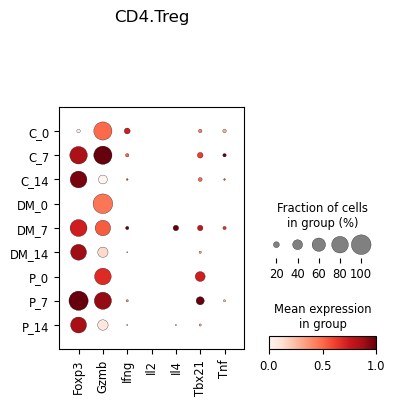

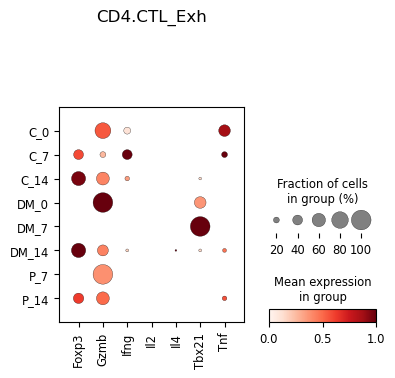

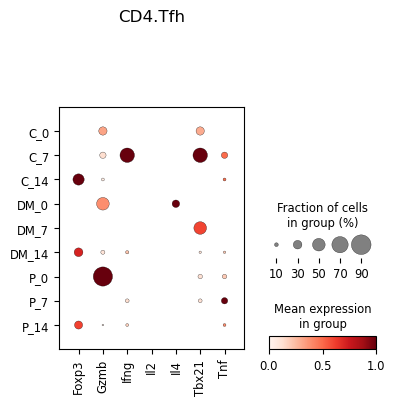

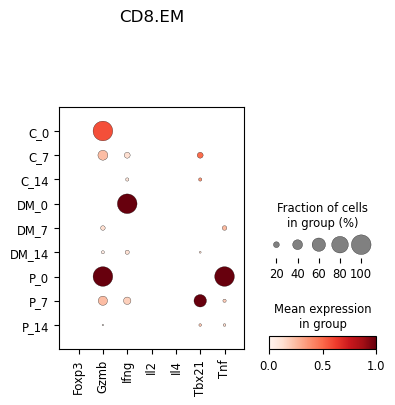

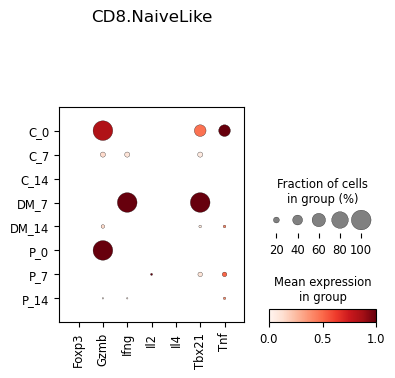

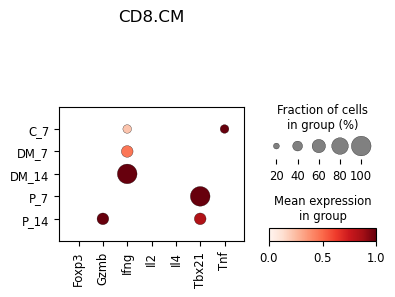

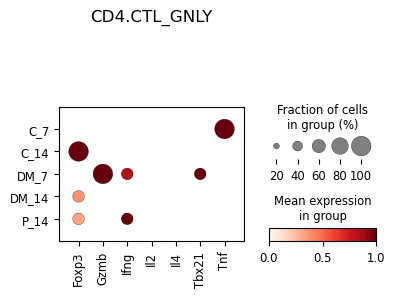

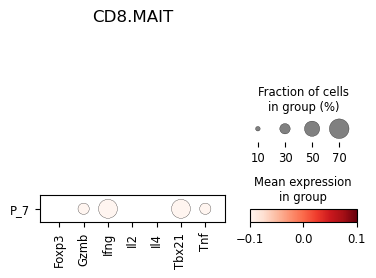

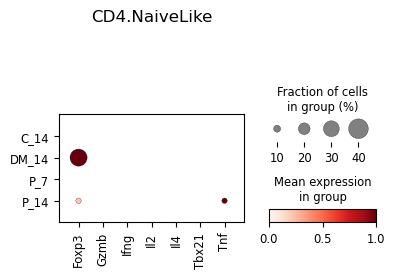

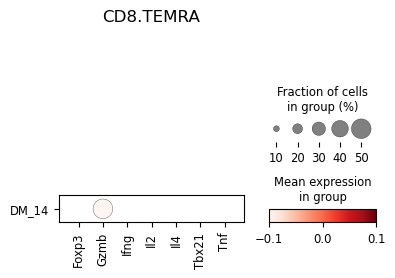

In [10]:
interesting_genes = ["Tnf", "Ifng", "Il2", "Gzmb", "Tbx21", "Foxp3", "Il4"]
adata_only_annotatedTC.obs.Tcell_subtype
subtypes = adata_only_annotatedTC.obs.Tcell_subtype.unique()

for subtype in subtypes:
    adata = adata_only_annotatedTC[adata_only_annotatedTC.obs.Tcell_subtype == subtype].copy()
    interesting_genes_in_adata = np.unique([gene for gene in interesting_genes if gene in adata.var_names])
    sc.pl.dotplot(adata, interesting_genes_in_adata, groupby=["condition", "day"], standard_scale="var", swap_axes=False, cmap="Reds", title=subtype)

### transcriptionfacotors

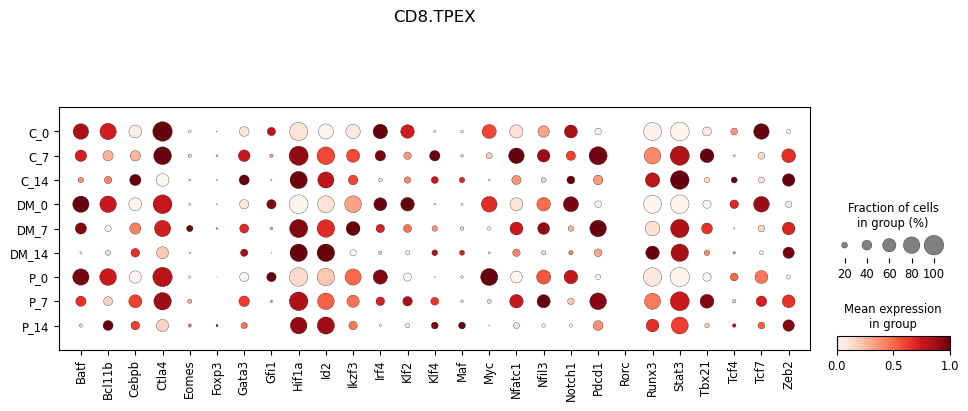

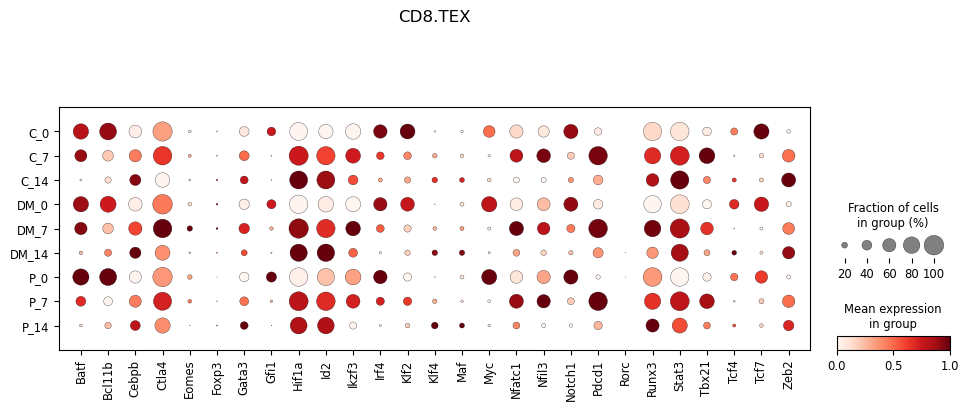

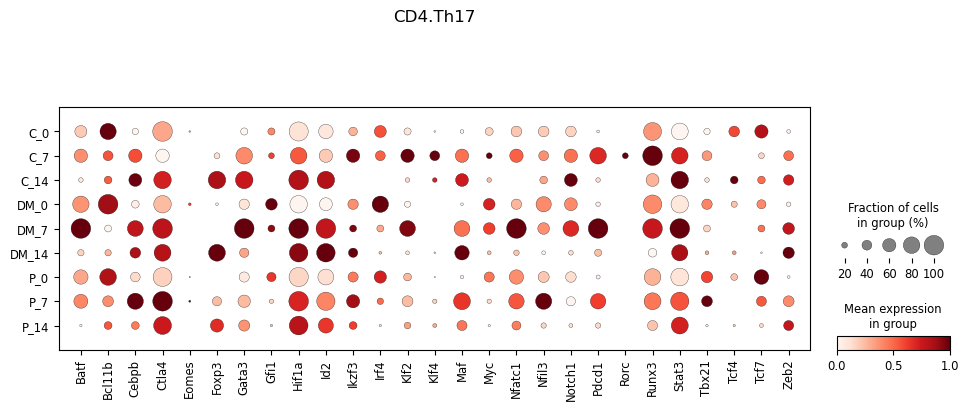

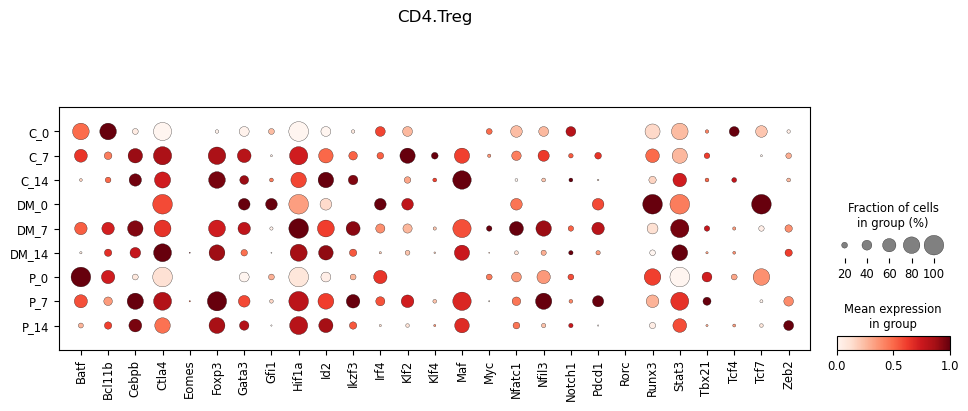

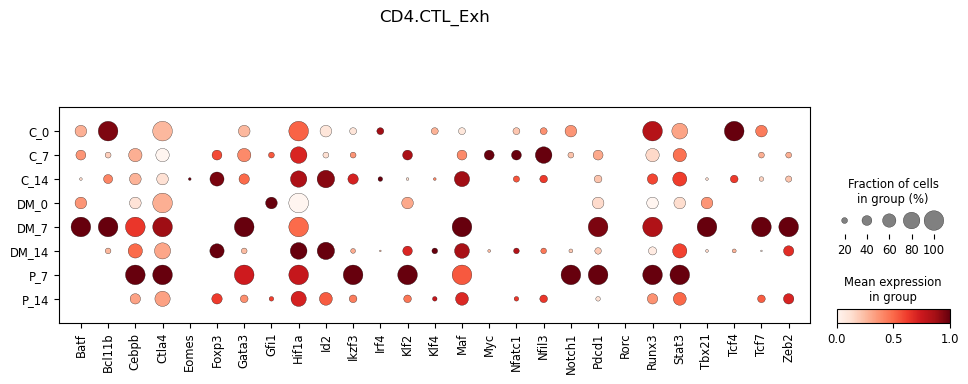

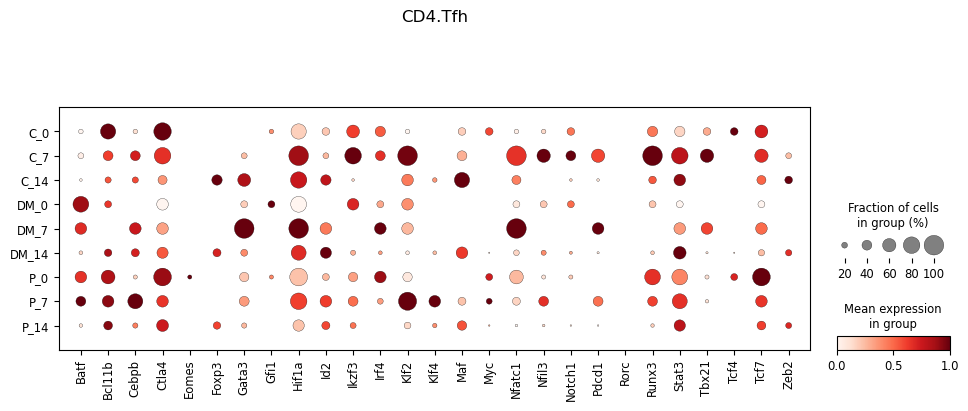

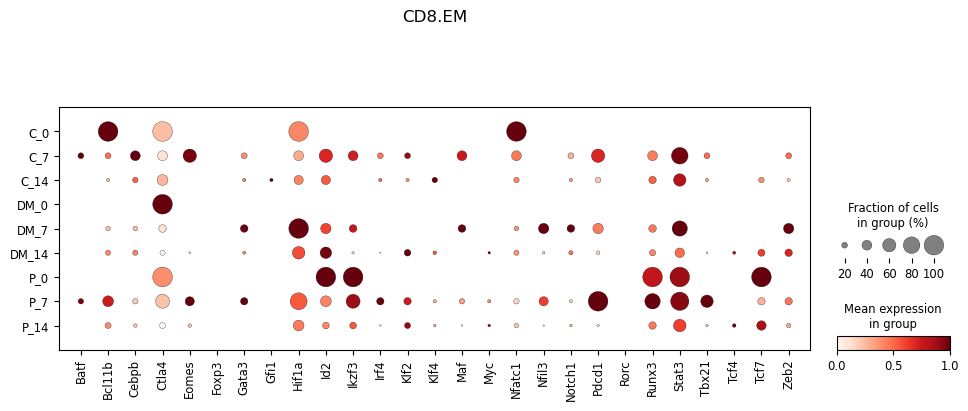

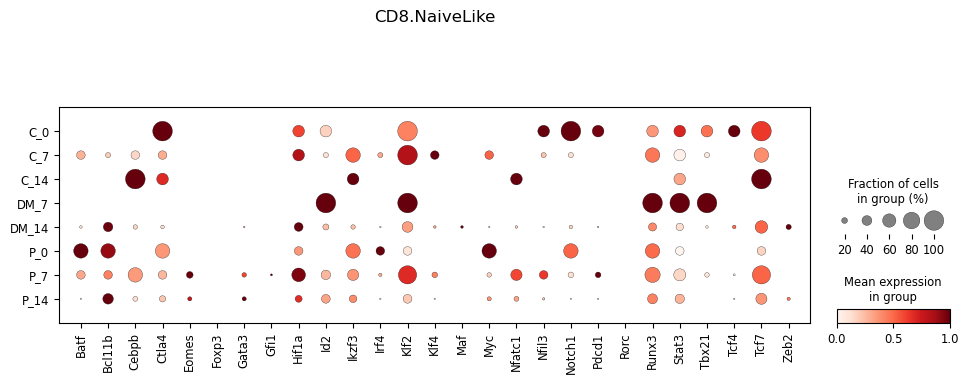

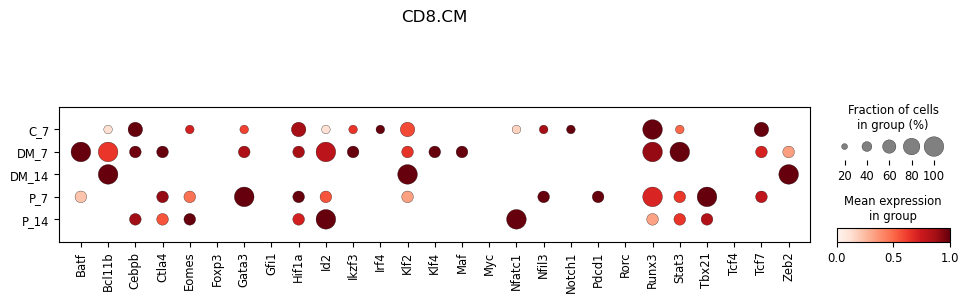

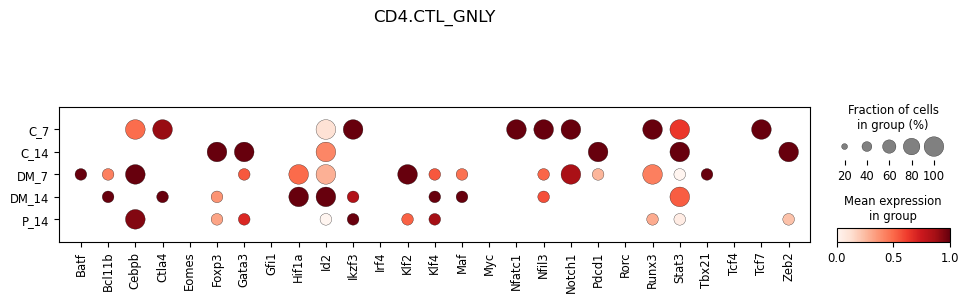

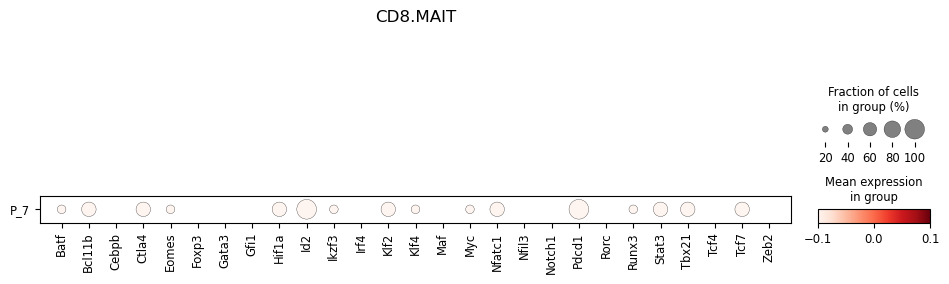

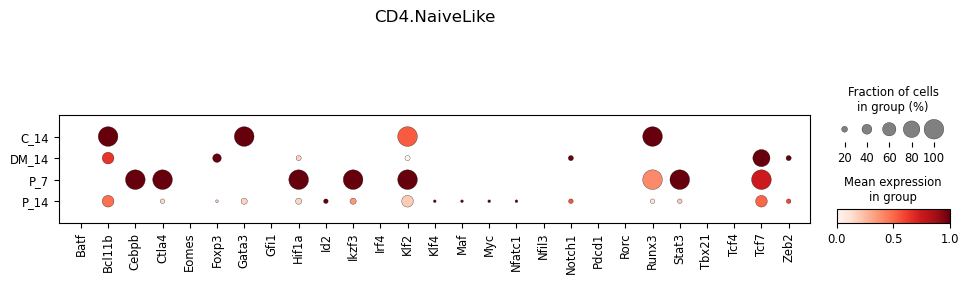

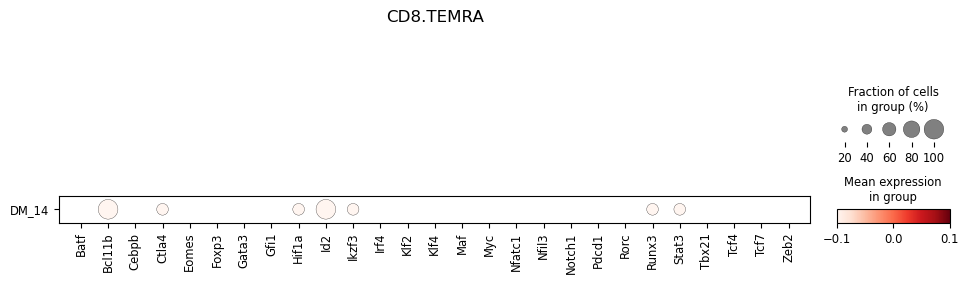

In [11]:
mouse_tcell_transcription_factors = [
    "Tcf7",         # Key for T-cell development (important for naïve T cells and differentiation)
    "Gata3",        # Important for Th2 differentiation
    "Tbx21",        # Critical for Th1 differentiation (mouse ortholog of T-bet)
    "Rorc",         # Master regulator for Th17 differentiation
    "Foxp3",        # Essential for Treg development
    "Eomes",         # Important for CD8+ T cell development and function
    "Runx3",        # Important for CD8+ T cell differentiation
    "Notch1",       # Key for early T-cell development and lineage commitment
    "Bcl11b",       # Essential for T-cell commitment and differentiation
    "Id2",          # Involved in early T-cell progenitor development
    "Zeb2",         # Involved in T-cell lineage commitment
    "Blimp1",       # Important for differentiation of effector T-cells, including CD8+ cytotoxic T-cells
    "Tcf1",         # Important for T-cell memory development
    "Nfatc1",       # Key for T-cell activation and differentiation
    "Ap-1",         # Affects T-cell activation and cytokine production
    "Stat5",        # Important for T-cell survival, proliferation, and differentiation
    "Stat3",        # Critical for Th17 differentiation and immune responses
    "Nfil3",        # Regulator of innate lymphoid cell (ILC) development, and impacts CD8+ T cells
    "Batf",         # Involved in Th17 differentiation and function
    "Myc",          # Regulates T-cell metabolism and effector function
    "Klf2",         # Important for T-cell homeostasis and function
    "Hif1a",        # Regulates metabolic adaptation in T-cells, especially in CAR T-cells
    "Tcf4",         # Regulates memory T-cell differentiation
    "Cebpb",        # Regulates immune response, including in CD8+ T cells
    "Gfi1",         # Regulates differentiation and effector function of T-cells
    "Irf4",         # Involved in T-helper differentiation and effector function
    "Ikzf3",        # Controls differentiation and function of CD4+ T-cells and Tregs
    "Maf",          # Important for Th17 and other T-helper subsets
    "Klf4",         # Plays a role in T-cell differentiation and immune responses
    "Tbx21",        # Key regulator of Th1 differentiation (mouse ortholog of T-bet)
    "Ctla4",        # Regulator of T-cell activation (important for T-cell exhaustion)
    "Pdcd1",        # Marker for T-cell exhaustion, also plays a role in CAR T-cell function (mouse ortholog of PD-1)
]
adata_only_annotatedTC.obs.Tcell_subtype
subtypes = adata_only_annotatedTC.obs.Tcell_subtype.unique()

for subtype in subtypes:
    adata = adata_only_annotatedTC[adata_only_annotatedTC.obs.Tcell_subtype == subtype].copy()
    tfs_in_adata = np.unique([gene for gene in mouse_tcell_transcription_factors if gene in adata.var_names])
    sc.pl.dotplot(adata, tfs_in_adata, groupby=["condition", "day"], standard_scale="var", swap_axes=False, cmap="Reds", title=subtype)

# try pseudobulk analysis

### first get raw count matrix again

In [ ]:
%R file_path <- "./01_data/processed/merged_and_processed/XXXCAR_genome/XXXCAR_genome_after_qc_TIL_only_pure_TC_annotation_non_TC_filtered_TC_subtypes_annotated.RData"
%R load(file_path)
%R DefaultAssay(scgate.projected) <- "RNA"
# %R sbst <- subset(scgate.projected, subset = is.na(functional.cluster))
%R sbst <- subset(scgate.projected, cells = rownames(scgate.projected@meta.data)[!is.na(scgate.projected@meta.data$functional.cluster)])
%R print(sbst)
%R raw_mat <- t(GetAssayData(sbst, slot = "counts")) 
%R print(max(raw_mat))
%R -o raw_mat



An object of class Seurat 
34747 features across 3456 samples within 3 assays 
Active assay: RNA (33696 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 2 other assays present: HTO, integrated
 2 dimensional reductions calculated: pca, umap
[1] 1501


'value'

In [ ]:
oa.extract_replicate(adata_only_annotatedTC, 'Classification')

In [ ]:
diff_adata = adata_only_annotatedTC.copy()
diff_adata.obs = diff_adata.obs[['day', 'condition', 'replicate', 'Tcell_subtype']]
diff_adata.layers["norm"] = diff_adata.X.copy()
diff_adata.layers["raw"] = raw_mat.copy()
diff_adata.X = raw_mat
np.max(diff_adata.X)

1501.0

In [ ]:
diff_adata.obs["sample"] = [
    f"{rep}_{l}" for rep, l in zip(diff_adata.obs["replicate"], diff_adata.obs["condition"])
]
diff_adata.obs["replicate"] = diff_adata.obs["replicate"].astype("category")
diff_adata.obs["condition"] = diff_adata.obs["condition"].astype("category")
diff_adata.obs["sample"] = diff_adata.obs["sample"].astype("category")
diff_adata.obs["Tcell_subtype"] = diff_adata.obs["Tcell_subtype"].astype("category")

In [ ]:
def aggregate_and_filter(
    adata,
    cell_identity,
    donor_key="sample",
    condition_key="condition",
    cell_identity_key="Tcell_subtype",
    obs_to_keep=None,  # which additional metadata to keep, e.g. gender, age, etc.
    replicates_per_patient=1,
):
    # subset adata to the given cell identity
    if obs_to_keep is None:
        obs_to_keep = []
    adata_cell_pop = adata[adata.obs[cell_identity_key] == cell_identity].copy()
    # check which donors to keep according to the number of cells specified with NUM_OF_CELL_PER_DONOR
    # size_by_donor = adata_cell_pop.obs.groupby([donor_key], observed=True).size()
    # donors_to_drop = [
    #     donor
    #     for donor in size_by_donor.index
    #     if size_by_donor[donor] <= NUM_OF_CELL_PER_DONOR
    # ]
    # if len(donors_to_drop) > 0:
    #     print("Dropping the following samples:")
    #     print(donors_to_drop)
    df = pd.DataFrame(columns=[*adata_cell_pop.var_names, *obs_to_keep])

    adata_cell_pop.obs[donor_key] = adata_cell_pop.obs[donor_key].astype("category")
    for i, donor in enumerate(donors := adata_cell_pop.obs[donor_key].cat.categories):
        # print(f"\tProcessing donor {i+1} out of {len(donors)}...", end="\r")
        # if donor not in donors_to_drop:
        adata_donor = adata_cell_pop[adata_cell_pop.obs[donor_key] == donor]
        # create replicates for each donor
        # indices = list(adata_donor.obs_names)
        # random.shuffle(indices)
        # indices = np.array_split(np.array(indices), replicates_per_patient)
        # for i, rep_idx in enumerate(indices):
        adata_replicate = adata_donor.copy()
        # specify how to aggregate: sum gene expression for each gene for each donor and also keep the condition information
        agg_dict = {gene: "sum" for gene in adata_replicate.var_names}
        for obs in obs_to_keep:
            agg_dict[obs] = "first"
        # create a df with all genes, donor and condition info
        df_donor = pd.DataFrame(adata_replicate.X.toarray())
        df_donor.index = adata_replicate.obs_names
        df_donor.columns = adata_replicate.var_names
        df_donor = df_donor.join(adata_replicate.obs[obs_to_keep])
        # aggregate
        df_donor = df_donor.groupby(donor_key).agg(agg_dict)
        df_donor[donor_key] = donor
        df.loc[f"donor_{donor}_{i}"] = df_donor.loc[donor]
    # print("\n")
    # create AnnData object from the df
    adata_cell_pop = sc.AnnData(
        df[adata_cell_pop.var_names], obs=df.drop(columns=adata_cell_pop.var_names)
    )
    return adata_cell_pop

In [ ]:
obs_to_keep = ["condition", "Tcell_subtype", "replicate", "sample"]
# process first cell type separately...
cell_type = diff_adata.obs["Tcell_subtype"].cat.categories[0]
print(
    f'Processing {cell_type} (1 out of {len(diff_adata.obs["Tcell_subtype"].cat.categories)})...'
)
adata_pb = aggregate_and_filter(diff_adata, cell_type, obs_to_keep=obs_to_keep)
for i, cell_type in enumerate(diff_adata.obs["Tcell_subtype"].cat.categories[1:]):
    print(
        f'Processing {cell_type} ({i+2} out of {len(diff_adata.obs["Tcell_subtype"].cat.categories)})...'
    )
    adata_cell_type = aggregate_and_filter(diff_adata, cell_type, obs_to_keep=obs_to_keep)
    adata_pb = adata_pb.concatenate(adata_cell_type)